# Matbench Perovskite Dataset

Exploratory Data Analysis (EDA). [MPContribs link](https://ml.materialsproject.org/projects/matbench_perovskites)


In [ ]:
# matminer needed for loading data
!pip install pymatviz matminer

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
from matbench_discovery.structure.prototype import get_protostructure_label
from matminer.datasets import load_dataset
from tqdm import tqdm

import pymatviz as pmv
from pymatviz.enums import Key


pmv.set_plotly_template("pymatviz_white")


__author__ = "Janosh Riebesell"
__date__ = "2022-03-19"


# make plotly figures render both locally and on GitHub.
# https://github.com/plotly/plotly.py/issues/931#issuecomment-2098209279
pio.renderers.default = "png"

In [ ]:
df_perov = load_dataset("matbench_perovskites")

moyo_spg_num_key = "moyopy_spg_num"
df_perov[moyo_spg_num_key] = [
    struct.get_symmetry_dataset(backend="moyopy", return_raw_dataset=True).number
    for struct in tqdm(df_perov[Key.structure])
]
df_perov[Key.volume] = df_perov[Key.structure].map(lambda struct: struct.volume)

df_perov[Key.formula] = df_perov[Key.structure].map(lambda cryst: cryst.formula)

df_perov[Key.crystal_system] = df_perov[moyo_spg_num_key].map(
    pmv.utils.spg_to_crystal_sys
)

100%|██████████| 18928/18928 [00:03<00:00, 6209.99it/s]


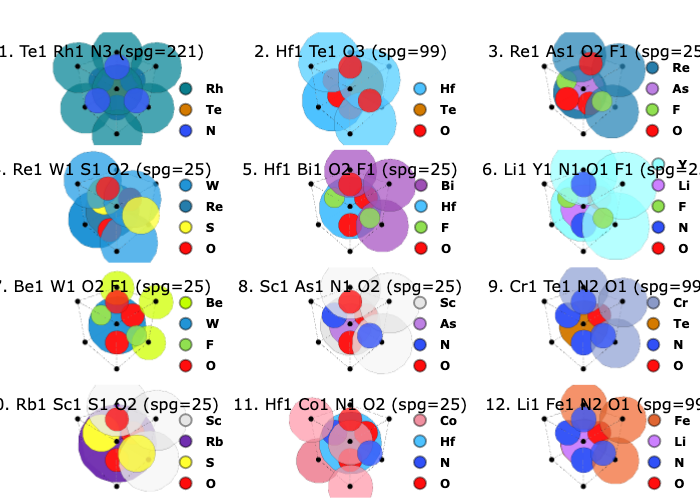

In [ ]:
fig = pmv.structure_3d(df_perov[Key.structure].iloc[:12])
fig.layout.paper_bgcolor = "rgba(255, 255, 255, 0.5)"
fig.show()

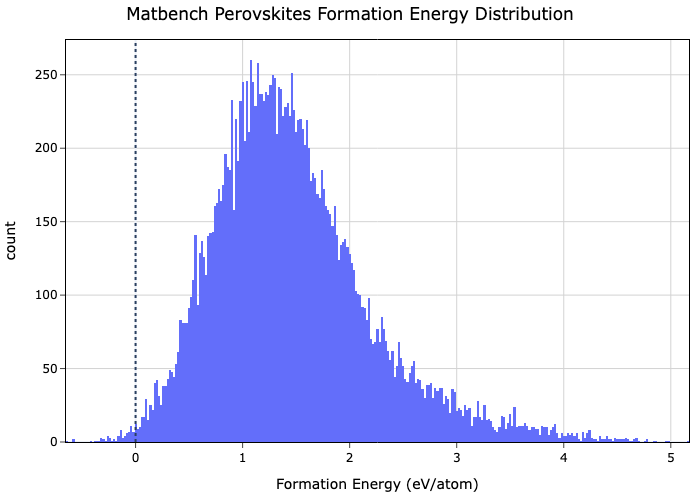

In [ ]:
labels = {"e_form": "Formation Energy (eV/atom)"}

fig = px.histogram(df_perov, x="e_form", nbins=300, labels=labels)

title = "Matbench Perovskites Formation Energy Distribution"
fig.layout.title.update(text=title, x=0.5)
fig.layout.margin.update(b=10, l=10, r=10, t=40)

fig.add_vline(x=0, fillcolor="black", line=dict(width=2, dash="dot"))

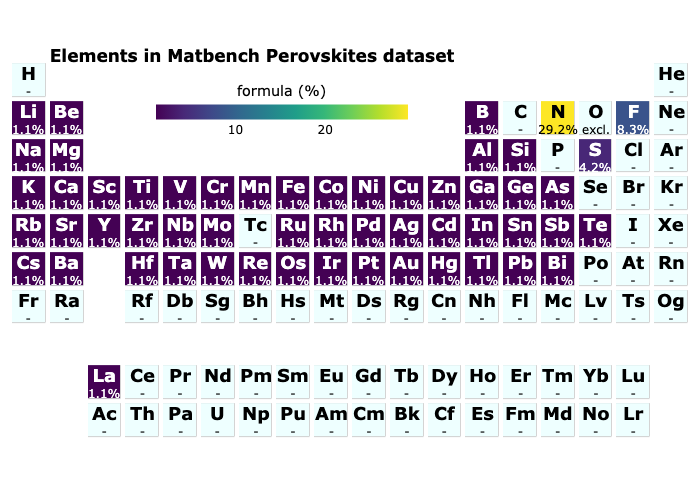

In [ ]:
fig = pmv.ptable_heatmap_plotly(
    df_perov[Key.formula], exclude_elements=["O"], heat_mode="percent"
)
title = "<b>Elements in Matbench Perovskites dataset</b>"
fig.layout.title.update(text=title, x=0.36, y=0.9)
fig.show()

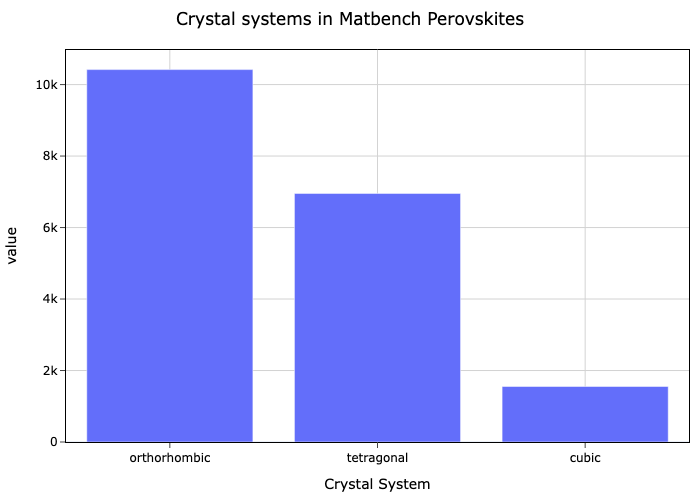

In [ ]:
fig = px.bar(df_perov[Key.crystal_system].value_counts())
fig.layout.title.update(text="Crystal systems in Matbench Perovskites", x=0.5)
fig.layout.update(showlegend=False, margin_t=50)
fig.show()

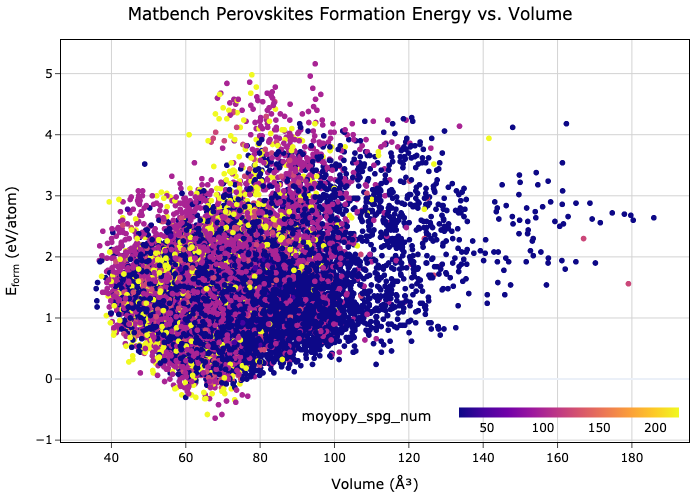

In [ ]:
fig = px.scatter(df_perov, x="volume", y="e_form", color=moyo_spg_num_key)
fig.layout.title = dict(text="Matbench Perovskites Formation Energy vs. Volume", x=0.5)
fig.layout.coloraxis.colorbar.update(
    orientation="h", y=0, x=1, xanchor="right", thickness=10, len=0.6
)
fig.layout.margin.update(b=10, l=10, r=10, t=40)
fig.show()

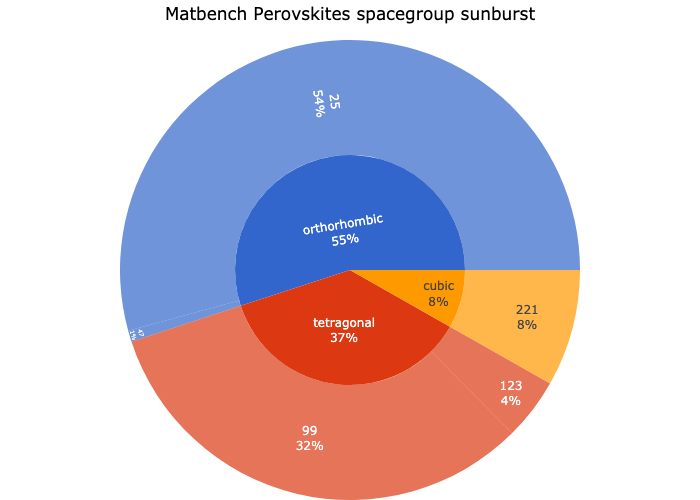

In [ ]:
fig = pmv.spacegroup_sunburst(df_perov[moyo_spg_num_key], show_counts="percent")
fig.layout.title.update(text="Matbench Perovskites spacegroup sunburst", x=0.5)
fig.layout.margin.update(b=0, l=0, r=0, t=40)
fig.show()

In [ ]:
df_perov[Key.protostructure_moyo] = df_perov[Key.structure].map(
    get_protostructure_label
)
df_perov[Key.protostructure_moyo].value_counts()

In [ ]:
# originally generated with aviary calling out to Aflow CLI, takes ~6h when running
# uninterrupted. see https://github.com/CompRhys/aviary/blob/14b2ab204ec/aviary/wren/utils.py#L158
aflow_protostructure_key = "aflow_wyckoff"
df_perov[f"{Key.protostructure}_aflow"] = pd.read_csv(
    # 2022-05-17-matbench_perovskites_aflow_labels.csv
    "https://docs.google.com/spreadsheets/d/"
    "1Mhk5t3Ac_aHOTWMjZ1DL4LtUBIB21nWt7oy2t3M-fQU/export?format=csv"
)[aflow_protostructure_key]

In [ ]:
# uncomment line to cache expensive aflow results
# %store df_perov

# uncomment line to reload cached dataframe
%store -r df_perov

no stored variable or alias df_perov


extract spacegroups and crystal systems from Aflow Wyckoff labels


In [ ]:
aflow_spg_num_key = "aflow_spg_num"
df_perov[aflow_spg_num_key] = (
    df_perov[aflow_protostructure_key].str.split("_").str[2].astype(int)
)
df_perov["aflow_crys_sys"] = df_perov[aflow_spg_num_key].map(
    pmv.utils.spg_to_crystal_sys
)

Surprisingly large disparity between Spglib and Aflow spacegroups

Spglib is fast while Aflow uses a slower adaptive but presumably more correct algorithm.



sankey-spglib-vs-aflow-spacegroups.svg:
Done in 79 ms!
10.74 KiB - 37.1% = 6.752 KiB


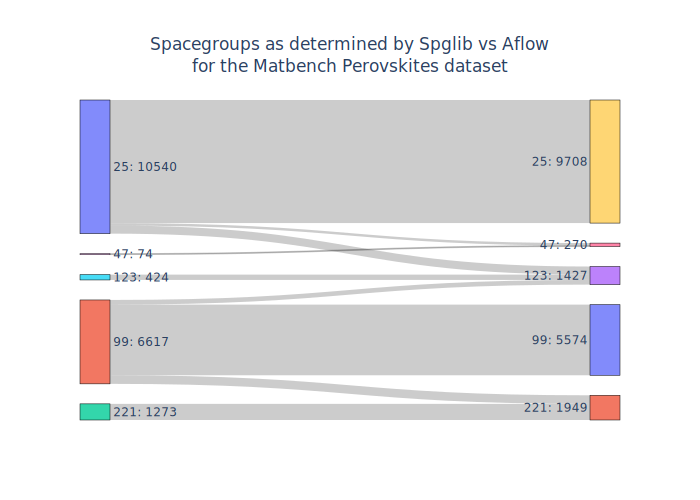

In [ ]:
fig = pmv.sankey_from_2_df_cols(df_perov, [moyo_spg_num_key, aflow_spg_num_key])
title = "Spglib vs Aflow Spacegroups<br>for the Matbench Perovskites dataset"
fig.layout.title = dict(text=title, x=0.5)
fig.show()

# pmv.io.save_and_compress_svg(fig, "sankey-spglib-vs-aflow-spacegroups")

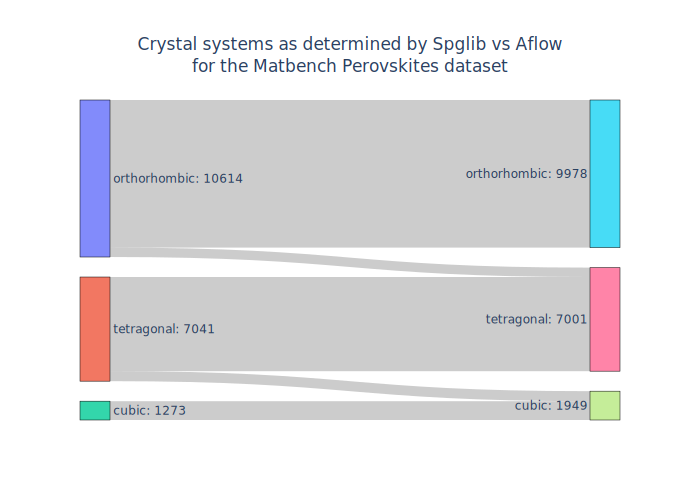

In [ ]:
fig = pmv.sankey_from_2_df_cols(df_perov, ["spglib_crys_sys", "aflow_crys_sys"])
title = "Spglib vs Aflow Crystal systems<br>for the Matbench Perovskites dataset"
fig.layout.title = dict(text=title, x=0.5)
fig.show()